In [ ]:
!pip install geojson

In [4]:
from pathlib import Path
import json
import datetime

import geojson

from eolearn.io import ImportFromTiffTask
from eolearn.core import OverwritePermission, FeatureType
from eolearn.io import ExportToTiffTask
from eolearn.geometry.transformations import RasterToVectorTask, VectorToRasterTask
from eolearn.io.geometry_io import VectorImportTask

import numpy as np

import matplotlib.pyplot as plt

In [5]:
# Define no data
no_data_value = 2**8-1

In [7]:
fpath_geotiff = Path('/home/data/mydata')
fpath_geotiff = list(fpath_geotiff.glob('*observe*.tif'))
fpath_geotiff

[PosixPath('/home/data/mydata/observedevent.tif')]

In [15]:
idx = 0
# Read flood geotiff
eop = ImportFromTiffTask(feature=(FeatureType.DATA_TIMELESS, 'flood'),
                       folder=fpath_geotiff[idx])
                       # image_dtype=np.uint8,
                       # no_data_value=0)
eop = eop.execute()
eop

EOPatch(
  data_timeless={
    flood: numpy.ndarray(shape=(5266, 6178, 1), dtype=float64)
  }
  bbox=BBox(((704683.458, 5707372.1246), (766463.458, 5760032.1246)), crs=CRS('32631'))
)

In [ ]:
# eop.mask_timeless['oil'][500:700, 500:900, 0] = 255

In [16]:
np.unique(eop.data_timeless['flood'])

array([-3.40282347e+38,  0.00000000e+00,  1.00000000e+00])

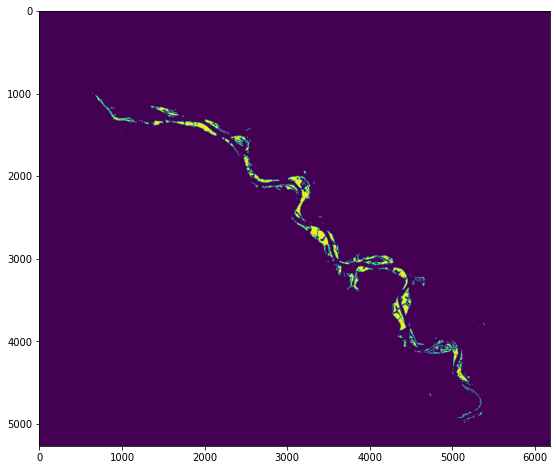

In [18]:
fig, ax = plt.subplots(figsize=(15, 8))
plt.imshow(eop.data_timeless['flood'], vmin=0, vmax=1)

In [19]:
eop.data_timeless['flood'][eop.data_timeless['flood'] < 0] = no_data_value
eop.data_timeless['flood'] = eop.data_timeless['flood'].astype(np.uint8)
np.unique(eop.data_timeless['flood'])

array([  0,   1, 255], dtype=uint8)

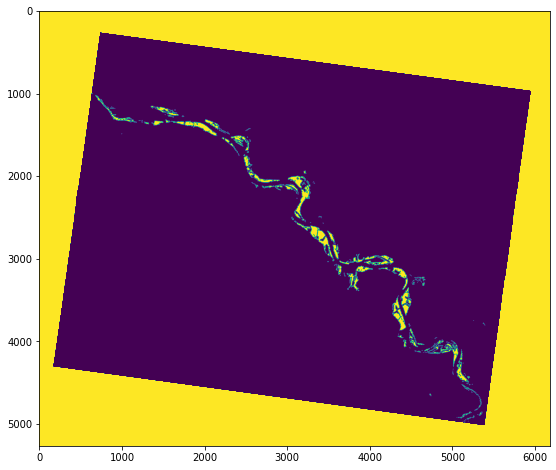

In [20]:
fig, ax = plt.subplots(figsize=(15, 8))
plt.imshow(eop.data_timeless['flood'], vmin=0, vmax=1)

In [22]:
# Save as GeoTIFF
export_tiff = ExportToTiffTask(feature=(FeatureType.DATA_TIMELESS, 'flood'),
                               folder=fpath_geotiff[idx].parent/(fpath_geotiff[idx].stem+'_converted.tif'),
                               date_indices=None,
                               no_data_value=no_data_value,
                               image_dtype=np.uint8)
                               # compress='DEFLATE')
export_tiff.execute(eop);

In [ ]:
# eop.plot((FeatureType.MASK_TIMELESS, 'oil'))

In [6]:
eop_new = eop.copy()
eop_new.bbox = eop.bbox

In [8]:
print(eop.bbox)

21.842773515061342,40.12878480606537,22.10907078501535,40.30404142098529


In [ ]:
eop_new

In [28]:
polyph_task = VectorImportTask((FeatureType.VECTOR_TIMELESS, 'polyphytos'),
                               '/home/data/mydata/polyphytos_reservoir.shp',
                               reproject=True,
                               clip=True)
eop_polyph = polyph_task.execute(bbox=eop_new.bbox)
eop_polyph

EOPatch(
  vector_timeless={
    polyphytos: geopandas.GeoDataFrame(columns=['Name', 'descriptio', 'timestamp', 'begin', 'end', 'altitudeMo', 'tessellate', 'extrude', 'visibility', 'drawOrder', 'icon', 'geometry'], length=1, crs=EPSG:4326)
  }
  bbox=BBox(((21.842773515061342, 40.12882326251892), (22.10907078501535, 40.30404142098529)), crs=CRS('4326'))
)

In [29]:
# eop_polyph.plot((FeatureType.VECTOR_TIMELESS, 'polyphytos'))

In [30]:
eop_new.vector_timeless['polyphytos'] = eop_polyph.vector_timeless['polyphytos']
eop_new

EOPatch(
  mask_timeless={
    oil: numpy.ndarray(shape=(1689, 2567, 1), dtype=uint8)
  }
  vector_timeless={
    polyphytos: geopandas.GeoDataFrame(columns=['Name', 'descriptio', 'timestamp', 'begin', 'end', 'altitudeMo', 'tessellate', 'extrude', 'visibility', 'drawOrder', 'icon', 'geometry'], length=1, crs=EPSG:4326)
  }
  bbox=BBox(((21.842773515061342, 40.12882326251892), (22.10907078501535, 40.30404142098529)), crs=CRS('4326'))
)

In [31]:
# Rasterize vector
v2r = VectorToRasterTask(vector_input=(FeatureType.VECTOR_TIMELESS, 'polyphytos'),
                     raster_feature=(FeatureType.MASK_TIMELESS, 'polyphytos_raster'),
                     values=[0, 1],
                     values_column='tessellate',
                     no_data_value=0,
                     raster_dtype=np.uint8,
                     raster_shape=eop_new.mask_timeless['oil'].shape[:2])

eop_v_r = v2r.execute(eop_new)
eop_v_r

/usr/local/lib/python3.9/site-packages/eolearn/geometry/transformations.py:214: EORuntimeWarning: Given vector polygons contain some 3D geometries, they will be projected to 2D
  warnings.warn(


EOPatch(
  mask_timeless={
    oil: numpy.ndarray(shape=(1689, 2567, 1), dtype=uint8)
    polyphytos_raster: numpy.ndarray(shape=(1689, 2567, 1), dtype=uint8)
  }
  vector_timeless={
    polyphytos: geopandas.GeoDataFrame(columns=['Name', 'descriptio', 'timestamp', 'begin', 'end', 'altitudeMo', 'tessellate', 'extrude', 'visibility', 'drawOrder', 'icon', 'geometry'], length=1, crs=EPSG:4326)
  }
  bbox=BBox(((21.842773515061342, 40.12882326251892), (22.10907078501535, 40.30404142098529)), crs=CRS('4326'))
)

In [32]:
np.unique(eop_new.mask_timeless['polyphytos_raster'])

array([0, 1], dtype=uint8)

In [33]:
lw_mask = eop_new.mask_timeless['polyphytos_raster'].astype('bool')

In [34]:
# fig, ax = plt.subplots(figsize=(15, 8))
# ppp = ax.imshow(lw_mask)
# fig.colorbar(ppp, ax=ax)

In [35]:
eop_new.mask_timeless['oil'][~lw_mask] = no_data_value

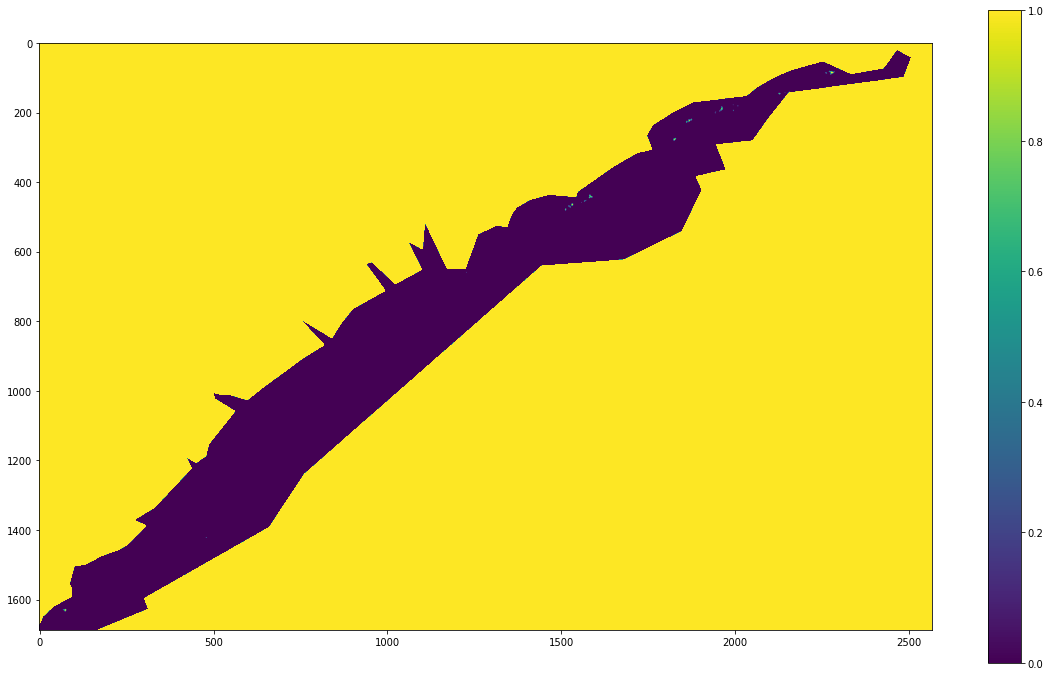

In [36]:
fig, ax = plt.subplots(figsize=(20, 12))
ppp = ax.imshow(eop_new.mask_timeless['oil'], vmin=0, vmax=1)
fig.colorbar(ppp, ax=ax)

In [37]:
# Save as GeoTIFF
export_tiff = ExportToTiffTask(feature=(FeatureType.MASK_TIMELESS, 'oil'),
                               folder=fpath_geotiff[idx].parent/(fpath_geotiff[idx].stem+'_test.tif'),
                               date_indices=None,
                               no_data_value=no_data_value,
                               image_dtype=np.uint8,
                               crs='EPSG:32634')
                               # compress='DEFLATE')
export_tiff.execute(eop_new);

#### Create statistics json (hardcode)

In [ ]:
eop_new.mask_timeless['oil']

In [147]:
fname_elems = fpath_geotiff[idx].stem.split('_')
fname_elems

['extremeevent-oilspill', 'polyphytos', '20210118', 'SENT2', 'm10']

In [148]:
eop_new.bbox.crs.ogc_string()

'EPSG:4326'

In [149]:
stats = [{}]
stats[0]['localId'] = fname_elems[1]
stats[0]['crs'] = eop_new.bbox.crs.ogc_string()
stats[0]['startDate'] = f'{fname_elems[2][:4]}-{fname_elems[2][4:6]}-{fname_elems[2][6:]}'
stats[0]['endDate'] = None
stats[0]['bbox'] = geojson.Feature(geometry=eop_new.bbox.geometry, properties={}).geometry['coordinates'][0][:-1]
stats[0]['producedDate'] = datetime.datetime.now(datetime.timezone.utc).isoformat().replace("+00:00", "Z")
stats[0]['dataFileName'] = fpath_geotiff[idx].name
stats[0]['metadataFileName'] = fpath_geotiff[idx].stem+'.xml'
stats[0]['pixelSize'] = [10, 10]
stats[0]['satellite'] = 'SENT2'
stats[0]['serviceName'] = fname_elems[0]
stats[0]['parameters'] = [{'measureType': 'oil-px-lake-px', 'value': 0.5},
                            {'measureType': 'occurrence-oil-spill-event', 'value': True},
                            {'measureType': 'circular-mean-orientation-oil-spill-segments', 'value': 45.0},
                            {'measureType': 'circular-standard-deviation-orientation-oil-spill-segments', 'value': 15.0},
                            {'measureType': 'mean-area-oil-spill-segments', 'value': 120.206418},
                            {'measureType': 'med-area-oil-spill-segments', 'value': 130},
                            {'measureType': 'std-area-oil-spill-segments', 'value': 60.206},
                            {'measureType': 'mean-eccentricity-oil-spill-segments', 'value': 0.5},
                            {'measureType': 'med-eccentricity-oil-spill-segments', 'value': 0.4},
                            {'measureType': 'std-eccentricity-oil-spill-segments', 'value': 0.2},
                            {'measureType': 'number-oil-spill-segments', 'value': 3}
                       ]

In [150]:
stats

[{'localId': 'polyphytos',
  'crs': 'EPSG:4326',
  'startDate': '2021-01-18',
  'endDate': None,
  'bbox': [[21.842774, 40.128823],
   [21.842774, 40.304041],
   [22.109071, 40.304041],
   [22.109071, 40.128823]],
  'producedDate': '2022-06-21T12:26:55.931381Z',
  'dataFileName': 'extremeevent-oilspill_polyphytos_20210118_SENT2_m10.tif',
  'metadataFileName': 'extremeevent-oilspill_polyphytos_20210118_SENT2_m10.xml',
  'pixelSize': [10, 10],
  'satellite': 'SENT2',
  'serviceName': 'extremeevent-oilspill',
  'parameters': [{'measureType': 'oil-px-lake-px', 'value': 0.5},
   {'measureType': 'occurrence-oil-spill-event', 'value': True},
   {'measureType': 'circular-mean-orientation-oil-spill-segments',
    'value': 45.0},
   {'measureType': 'circular-standard-deviation-orientation-oil-spill-segments',
    'value': 15.0},
   {'measureType': 'mean-area-oil-spill-segments', 'value': 120.206418},
   {'measureType': 'med-area-oil-spill-segments', 'value': 130},
   {'measureType': 'std-area-oi

In [151]:
with open (fpath_geotiff[idx].parent/(fpath_geotiff[idx].stem+'.json'), 'w', encoding='UTF-8') as json_f:
    json.dump(stats, json_f, indent=4)